In [ ]:
###############################################################################
#                          Libraries to use  
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [ ]:
###############################################################################
#                     ODE system Model solving  
###############################################################################

#Lodka-Volterra non linear model
def MakeModel(Alpha,Beta,Gamma,Delta,Variables):
    
    Equation1=Variables[0]*(Alpha-Beta*Variables[1])
    Equation2=-Variables[1]*(Gamma-Delta*Variables[0])
    
    return [Equation1,Equation2]

#Integration time
SolverTime=np.linspace(0,50,num=200)

#Parameters of the model 
alpha=0.25
beta=0.55
gamma=0.3
delta=0.6

#Initial conditions 
Int=np.array([3,1])  

#Model Solution 
def ODEModel(InitialConditions,t):

    return MakeModel(alpha,beta,gamma,delta,InitialConditions)

Solution=odeint(ODEModel,Int,SolverTime)

###############################################################################
#                           Visualization 
###############################################################################

plt.figure(figsize=(9,6))
plt.plot(SolverTime,Solution[:,0],'b-',label='Rabbits')
plt.plot(SolverTime,Solution[:,1],'g-',label='Wolfs')
plt.xlabel('Time')
plt.ylabel('Normalized Population')
plt.legend(loc='best')

plt.show()

#ax=plt.gca()
#PlotStyle(ax,'')

In [ ]:
#Lollipop plot based on the python graph gallery implementation 
def LollipopPlot(Fig,Time,Data,Regression):
    
    cTime=Time
    cData=Data
    cRegression=Regression
    
    ax=Fig.gca()

    (markers, stemlines, baseline) = ax.stem(cTime, cData, bottom=-0.4, label='Data', basefmt=" ")
    plt.setp(stemlines, linestyle="-", color="red", linewidth=0.5)
    plt.setp(markers, color="red")

    ax.plot(cTime,cRegression,'b-',label='Regression')
    ax.set_ylabel('Normalized Population')
    ax.set_xlabel('Time')
    ax.legend(loc='best')
    ax.set_ylim(-0.4,3.4)

###############################################################################
#                            Data generation  
###############################################################################
def MakeNoisyData(Data,Noise):
    
    return [val+cal for val,cal in zip(Data,Noise)]

WhiteNoise=[np.random.uniform(low=-1,high=1)/8 for val in Solution[:,1]]
WhiteSignal=MakeNoisyData(Solution[:,1],WhiteNoise)

###############################################################################
#                    ODE system model fitting  
###############################################################################

def ModelSolver(t,Alpha,Beta,Gamma,Delta,InitialConditions):
    
    cAlpha=Alpha
    cBeta=Beta
    cGamma=Gamma
    cDelta=Delta
    
    cInit=InitialConditions
    
    def LocalModel(cInit,t):
        
        return MakeModel(cAlpha,cBeta,cGamma,cDelta,cInit)
    
    Solution=odeint(LocalModel,cInit,t)
    
    return Solution[:,1]

def ModelFit(t,Alpha,Beta,Gamma,Delta):
    
    return ModelSolver(t,Alpha,Beta,Gamma,Delta,Int)
    
ModelParams01=curve_fit(ModelFit,SolverTime,WhiteSignal)
FitSolution=ModelSolver(SolverTime,ModelParams01[0][0],ModelParams01[0][1],ModelParams01[0][2],ModelParams01[0][3],Int)

###############################################################################
#                    Standard parameter estimation  
###############################################################################

fig=plt.figure(2,figsize=(9,6))
LollipopPlot(fig,SolverTime,WhiteSignal,FitSolution)
plt.show()

In [ ]:
###############################################################################
#                    Performance measurement
###############################################################################

#Measures the squared error between the data and the fit given an initial parameter guess
def SquaredError(InitialParameterGuess):
    
    try:
        #Some guesses will result in an error or an invalid integration 
        #this ensures that the error is estimated only for valid solutions 
        cModelParams=curve_fit(ModelFit,SolverTime,WhiteSignal,p0=InitialParameterGuess)
        cSolution=ModelSolver(SolverTime,cModelParams[0][0],cModelParams[0][1],cModelParams[0][2],cModelParams[0][3],Int)
    
        error=[(val-sal)**2 for val,sal in zip(cSolution,WhiteSignal)]
        
    except RuntimeError:
        
        #Based on the scale of the data the following list of values will be large enough to be rejected as a solution 
        error=[10,10]
    
    return sum(error)

###############################################################################
#                    Random Search of initial values  
###############################################################################

#Random selection of the initial guess values 
def RandomSearch(Iterations):
    
    nIt=Iterations 
    GuessContainer=[]
    ErrorContainer=[]
    
    for k in range(nIt):
        
        lGuess=[np.random.uniform(low=0,high=1) for val in range(4)]
        lerror=SquaredError(lGuess)
        
        GuessContainer.append(lGuess) #Contains the list of random initial values 
        ErrorContainer.append(lerror) #List of the errors 
    
    minError=np.min(ErrorContainer) #Min error value 
    minLocation=[j for j in range(nIt) if ErrorContainer[j]==minError] #Returns the location of the min value in the list
    
    bestGuess=GuessContainer[minLocation[0]] #Best initial value guess 
    
    return ErrorContainer,bestGuess

errs, bG=RandomSearch(10)    

###############################################################################
#                   Initial values Random Search Fitting 
###############################################################################

ModelParams02=curve_fit(ModelFit,SolverTime,WhiteSignal,p0=bG)
FitSolution2=ModelSolver(SolverTime,ModelParams02[0][0],ModelParams02[0][1],ModelParams02[0][2],ModelParams02[0][3],Int)

###############################################################################
#                              Visualization  
###############################################################################

fig=plt.figure(3,figsize=(9,6))
LollipopPlot(fig,SolverTime,WhiteSignal,FitSolution2)
plt.show()

In [ ]:
#Parameters for Model A
alpha=0.4
beta=1

#Matrix of coeficients for model A
#Model A is refered in this script as model 01
def MakeModelMatrix01(Alpha,Beta):
    Matrix=np.zeros((2,2))
    Matrix[0,0]=Alpha
    Matrix[0,1]=-Beta
    Matrix[1,0]=1
    return Matrix

#Integrating Model A
Matrix01=MakeModelMatrix01(alpha,beta)
Int=np.array([1,1])

def SODE(InitialConditions,t):
    return MakeModel(Matrix01,InitialConditions)

Solution=odeint(SODE,Int,SolverTime)

/Users/mardian/Documents/Notebook/env/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Notebook/env/lib/python3.7/site-packages/ipykernel_launcher.py:276: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


****** 0.8095186304266413 0.7868194086005896 3.844110884038975
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None]
  color or c: color
  contains: callable
  dash_capstyle: {'butt', 'round', 'projecting'}
  dash_joinstyle: {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style
  markeredgecolor or mec: color
  markeredgewidth or mew: float
  markerfacecolor or mfc: color
  ma

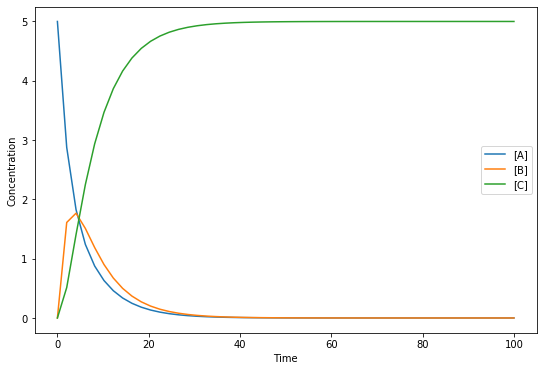

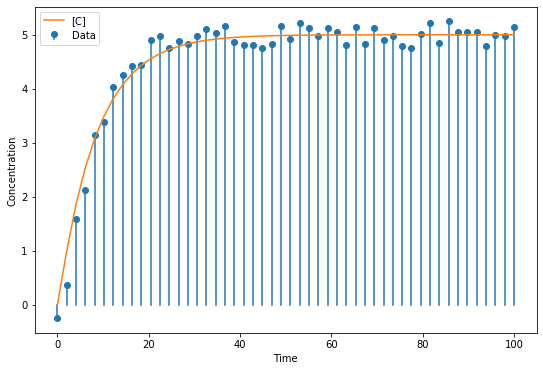

In [3]:
# -*- coding: utf-8 -*-

"""
@author: TavoGLC
From:
-Parameter estimation of differential equation models-
"""

###############################################################################
#                          Libraries to use  
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from scipy.integrate import odeint
from scipy.optimize import curve_fit

import scipy.stats as stats

###############################################################################
#                    General plot functions 
###############################################################################
'''
#Elimates the left and top lines and ticks in a matplotlib plot
def PlotStyle(Axes,Title):
    
    Axes.spines['top'].set_visible(False)
    Axes.spines['right'].set_visible(False)
    Axes.spines['bottom'].set_visible(True)
    Axes.spines['left'].set_visible(True)
    Axes.xaxis.set_tick_params(labelsize=14)
    Axes.yaxis.set_tick_params(labelsize=14)
    Axes.set_title(Title)
'''
###############################################################################
#                    General Model Construction 
###############################################################################

#Performs the dot produt to make the model 
def MakeModel(MatrixCoeficients,InitialConditions):
    
    return np.dot(MatrixCoeficients,InitialConditions)

###############################################################################
#                              ODE system solving  
###############################################################################
'''
SolverTime=np.linspace(0,20,num=150)

#Parameters for Model A
alpha=0.4
beta=1

#Matrix of coeficients for model A
#Model A is refered in this script as model 01
def MakeModelMatrix01(Alpha,Beta):
    
    Matrix=np.zeros((2,2))

    Matrix[0,0]=Alpha
    Matrix[0,1]=-Beta
    Matrix[1,0]=1
    
    return Matrix

#Integrating Model A
Matrix01=MakeModelMatrix01(alpha,beta)
Int=np.array([1,1])

def SODE(InitialConditions,t):
    
    return MakeModel(Matrix01,InitialConditions)

Solution=odeint(SODE,Int,SolverTime)

###############################################################################
#                    Visualisation
###############################################################################

DerivativeLabel=r'$\dfrac{d}{dt} f(t) $'
SolutionLabel=r'$f(t)$'

plt.figure(1,figsize=(9,6))

plt.plot(SolverTime,Solution[:,1],'b-',label=SolutionLabel,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(SolverTime,Solution[:,0],'g-',label=DerivativeLabel,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Displacement',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

ax=plt.gca()
#PlotStyle(ax,'')
'''
###############################################################################
#                        Data Generation
###############################################################################

#Element wise sum of two iterables of the same size, name makes reference to the output rather than the process
def MakeNoisyData(Data,Noise):
    
    return [val+cal for val,cal in zip(Data,Noise)]
'''
WhiteNoise=[np.random.uniform(low=-1,high=1)*3 for val in Solution[:,1]]
WhiteSignal=MakeNoisyData(Solution[:,1],WhiteNoise)

###############################################################################
#                              ODE fitting  
###############################################################################

#Function for parameter estimation
def ModelSolver01(t,Alpha,Beta,InitialConditions):
    
    cAlpha=Alpha
    cBeta=Beta
    cInit=InitialConditions
    
    cMatrix=MakeModelMatrix01(cAlpha,cBeta)
    
    def LocalModel(cInit,t):
        
        return MakeModel(cMatrix,cInit)
    
    Solution=odeint(LocalModel,cInit,t)
    
    return Solution[:,1]

def ModelSolution01(t,Alpha,Beta):
    
    return ModelSolver01(t,Alpha,Beta,Int)
    
Model01Params=curve_fit(ModelSolution01,SolverTime,WhiteSignal)

###############################################################################
#                    Fit solution
###############################################################################

fAlpha=Model01Params[0][0]
fBeta=Model01Params[0][1]

FitSolutionA=ModelSolution01(SolverTime,fAlpha,fBeta)

###############################################################################
#                    Visualization 
###############################################################################

plt.figure(2,figsize=(9,6))

(markers, stemlines, baseline) = plt.stem(SolverTime, WhiteSignal,bottom=-42,label='Data',basefmt=" ")
plt.setp(stemlines, linestyle="-", color="red", linewidth=0.5,alpha=0.5 )
plt.setp(markers, color="red",alpha=0.75 )

plt.plot(SolverTime,FitSolutionA,'b-',label=SolutionLabel,path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
    
plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Displacement',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

plt.ylim(-42,75)

ax=plt.gca()
#PlotStyle(ax,'')

###############################################################################
#                    Residuals Statistical test  
###############################################################################

ObRes=[signal-model for signal,model in zip(WhiteSignal,FitSolutionA)]

KS=stats.ks_2samp(ObRes,WhiteNoise)

print(KS)
'''
###############################################################################
#                              ODE system  solving  
###############################################################################

SolverTime=np.linspace(0, 100)

#Model B Parameters
k1=0.3
k2=0.25
k3=0.1

#Coeficients matrix for model B
#Model B is refered as model02
def MakeModelMatrix02(K1,K2,K3):
    
    Matrix=np.zeros((3,3))

    Matrix[0,0]=-K1
    Matrix[0,1]=K3

    Matrix[1,0]=K1
    Matrix[1,1]=-(K2+K3)

    Matrix[2,1]=K2
    
    return Matrix

Matrix02=MakeModelMatrix02(k1,k2,k3)
InitialConditions=[5,0,0]

def KineticsSystem(InitialConditions,t):
    
    return MakeModel(Matrix02,InitialConditions)

SystemSolution=odeint(KineticsSystem, InitialConditions, SolverTime)

###############################################################################
#                    Visualization
###############################################################################

plt.figure(figsize=(9,6))
plt.plot(SolverTime, SystemSolution[:,0], label='[A]')
plt.plot(SolverTime, SystemSolution[:,1], label='[B]')
plt.plot(SolverTime, SystemSolution[:,2], label='[C]')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

###############################################################################
#                            Data Generation
###############################################################################

WhiteNoise=[np.random.uniform(low=-1,high=1)/4 for val in SystemSolution[:,2]]
WhiteSignal=MakeNoisyData(SystemSolution[:,2],WhiteNoise)

###############################################################################
#                              ODE fitting  
###############################################################################

def ModelSolver02(t,K1,K2,K3,InitialConditions):
    
    cK1=K1
    cK2=K2
    cK3=K3
    
    cInit=InitialConditions
    
    cMatrix=MakeModelMatrix02(cK1,cK2,cK3)
    
    def LocalModel(cInit,t):
        
        return MakeModel(cMatrix,cInit)
    
    Solution=odeint(LocalModel,cInit,t)
    
    return Solution[:,2]

def ModelSolution02(t,K1,K2,K3):
    
    return ModelSolver02(t,K1,K2,K3,InitialConditions)
    
    
Model02Params=curve_fit(ModelSolution02, SolverTime, WhiteSignal)

fK1=Model02Params[0][0]
fK2=Model02Params[0][1]
fK3=Model02Params[0][2]
print('******', fK1, fK2, fK3)

FitSolutionB=ModelSolution02(SolverTime, fK1, fK2, fK3)

###############################################################################
#                        Visualization
###############################################################################

plt.figure(figsize=(9,6))

(markers, stemlines, baseline) = plt.stem(SolverTime, WhiteSignal, bottom=0, label='Data',basefmt=" ")
plt.setp(stemlines)
plt.setp(markers)

plt.plot(SolverTime, FitSolutionB, label='[C]') 
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

###############################################################################
#                    Residuals Statistical test  
###############################################################################

ObRes=[signal-model for signal,model in zip(WhiteSignal,FitSolutionB)]
KS=stats.ks_2samp(ObRes,WhiteNoise)
print(KS)

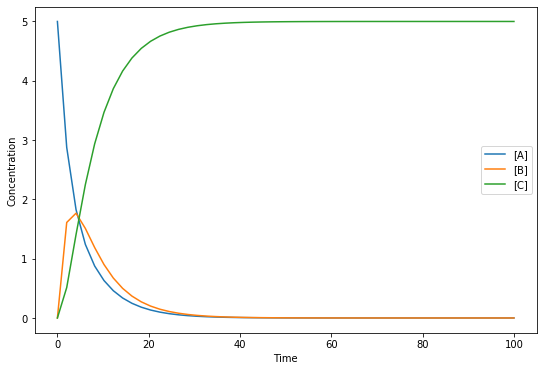

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import curve_fit

import scipy.stats as stats

def MakeModel(MatrixCoeficients, InitialConditions):
    
    return np.dot(MatrixCoeficients, InitialConditions)

SolverTime=np.linspace(0, 100)

#Model B Parameters
k1=0.3
k2=0.25
k3=0.1

#Coeficients matrix for model B
#Model B is refered as model02
def MakeModelMatrix02(K1,K2,K3):
    
    Matrix=np.zeros((3,3))

    Matrix[0,0]=-K1
    Matrix[0,1]=K3
    Matrix[1,0]=K1
    Matrix[1,1]=-(K2+K3)
    Matrix[2,1]=K2
    
    return Matrix

Matrix02=MakeModelMatrix02(k1,k2,k3)
InitialConditions=[5,0,0]

def KineticsSystem(InitialConditions,t):
    
    return MakeModel(Matrix02,InitialConditions)

SystemSolution=odeint(KineticsSystem, InitialConditions, SolverTime)

###############################################################################
#                    Visualization
###############################################################################

plt.figure(figsize=(9,6))
plt.plot(SolverTime, SystemSolution[:,0], label='[A]')
plt.plot(SolverTime, SystemSolution[:,1], label='[B]')
plt.plot(SolverTime, SystemSolution[:,2], label='[C]')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()